# Data preprocessing
### Input:

In [12]:
host = 'localhost'
database='roomekbot$offers'
user='root'
password='Ad4Gw2'
sql_query = "select * from offers where city = 'Warszawa' and business_type = 'rent' and housing_type = 'apartment'"

### Import database

In [70]:
import mysql.connector
from mysql.connector import Error

try:
    connection = mysql.connector.connect(host=host, database=database, user=user, password=password)
    cursor = connection.cursor()
    cursor.execute(sql_query)
    records = cursor.fetchall()
    
    sql_query = "describe offers"
    cursor = connection.cursor()
    cursor.execute(sql_query)
    titles = cursor.fetchall()
    titles = [x[0] for x in titles]
    
except Error as e:
    print("Error reading data from MySQL table", e)
finally:
    if (connection.is_connected()):
        connection.close()
        cursor.close()

### Create dataframe

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(data=records, columns=titles)
df.head()

AssertionError: 69 columns passed, passed data had 6 columns

### Statistics - show amount of empty cells

In [72]:
round(df.isnull().sum()/len(df)*1000)/10

offer_url                    0.0
city                         0.0
housing_type                 0.0
business_type                0.0
offer_name                   0.0
offer_thumbnail_url          0.0
price                        0.0
total_price                  0.0
street                       0.0
district                     0.0
date_of_the_offer            0.0
offer_id                     0.0
offer_text                   0.0
offer_from                   0.0
apartment_level              0.0
furniture                    0.0
type_of_building             0.0
area                         0.0
amount_of_rooms              0.0
additional_rent              0.0
price_per_m2                 0.0
type_of_market               0.0
security_deposit             0.0
building_material            0.0
windows                      0.0
heating                      0.0
building_year                0.0
fit_out                      0.0
ready_from                   0.0
type_of_ownership            0.0
          

### Replace None and Nan with mean value or 0

In [75]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
# specify which columns to replace with mean value...
# imputer = imputer.fit(df[:, 1:3])
# df[:, 1:3] = imputer.transform(df[:, 1:3])

# ... and which replace with zero:
# df[10:14] = df.fillna(0, inplace=True)

# or replace all with zeros:
df.fillna(0, inplace=True)
df.head()

,offer_url,city,housing_type,business_type,offer_name,offer_thumbnail_url,price,total_price,street,district,...,terrace,balcony,separate_kitchen,basement,virtual_walk,two_level_apartment,connecting_room,pet_friendly,creation_time,modification_time
0,https://www.olx.pl/oferta/2-oddzielne-pokoje-4...,Warszawa,apartment,rent,2 oddzielne pokoje 46 m wynajmę Nowe BEMOWO bl...,https://apollo-ireland.akamaized.net:443/v1/fi...,1699,1710.0,0,Bemowo,...,0.0,1.0,0.0,0.0,0,0,0.0,0.0,2019-11-21 19:48:20,0
1,https://www.olx.pl/oferta/2-pok-oddzielne-50-m...,Warszawa,apartment,rent,"2 pok oddzielne,50 m2,balkon,garaż,tuż przy me...",https://apollo-ireland.akamaized.net:443/v1/fi...,2000,2400.0,0,Ursynów,...,0.0,1.0,0.0,0.0,0,0,0.0,0.0,2019-11-21 19:47:43,0
2,https://www.olx.pl/oferta/2-pok-z-m-post-wloda...,Warszawa,apartment,rent,"2 pok z m. post. Włodarzewska, Szczęśliwice, O...",https://apollo-ireland.akamaized.net:443/v1/fi...,2490,2500.0,0,Ochota,...,0.0,1.0,0.0,0.0,0,0,0.0,0.0,2019-11-21 19:48:21,0
3,https://www.olx.pl/oferta/2-pokoje-40m2-srodmi...,Warszawa,apartment,rent,"2 pokoje, 40m2, Śródmieście / Wola , ul. Sienn...",https://apollo-ireland.akamaized.net:443/v1/fi...,2300,2310.0,Sienna,Śródmieście,...,1.0,1.0,0.0,0.0,0,0,0.0,0.0,2019-11-21 19:47:42,0
4,https://www.olx.pl/oferta/2-pokoje-50m2-zolibo...,Warszawa,apartment,rent,2 pokoje - 50m2 - ŻOLIBORZ - bezpłatna SIŁOWNIA,https://apollo-ireland.akamaized.net:443/v1/fi...,2300,2900.0,Powazkowska,Żoliborz,...,0.0,1.0,0.0,1.0,0,0,0.0,0.0,2019-11-21 19:49:22,0


### Select only valuable data

In [104]:
X = df.drop([
    'price',
    'parsed_fields',
    'offer_from',
    'offer_url',
    'offer_name',
    'offer_thumbnail_url',
    'offer_id',
    'offer_text',
    'creation_time',
    'modification_time',
    'city',
    'housing_type',
    'business_type',
    'pet_friendly',
    'rental_for_students',
    'non_smokers_only',
    'street'], axis=1)

X_text = X[['district',
            'apartment_level',
            'type_of_building',
            'type_of_market',
            'building_material',
            'windows',
            'heating',
            'type_of_ownership',
            'type_of_room',
            'preferred_locator',
            'fit_out']]

X_other = X[['location_latitude',
             'location_longitude',
#              'date_of_the_offer',
             'ready_from',
             'scraped_ranking',]]

X_irrelevant = X[['additional_rent',
             'building_year',
             'internet',
             'cable_tv',
             'bathtub',
             'utility_room',
             'terrace',
             'balcony',
             'separate_kitchen',
             'basement',
             'virtual_walk',
             'two_level_apartment',
             'connecting_room',
             'closed_terrain',
             'monitoring_or_security',
             'entry_phone',
             'antibulglar_doors_windows',
             'antibulglar_blinds',
             'alarm_system',
             'tv',
             'phone',
             'AC',
             'garden',
             'oven',
             'fridge',
             'cooker',
             'price_per_m2',
             'dishwasher',
             'washing_machine',
             'elevator',
             'security_deposit',]]

X = X.drop(list(X_text.columns)+list(X_other.columns)+list(X_irrelevant.columns), axis=1)
X.head()

,total_price,date_of_the_offer,furniture,area,amount_of_rooms,parking_space
0,1710.0,2019-11-21 15:16:00,1,46,2,0.0
1,2400.0,2019-11-21 18:45:00,0,45,2,1.0
2,2500.0,2019-11-21 15:24:00,1,43,2,1.0
3,2310.0,2019-11-21 18:16:00,1,40,2,0.0
4,2900.0,2019-11-21 18:09:00,1,50,2,0.0


### Scale date

In [105]:
now = pd.Timestamp.now()
X['date_of_the_offer'] = (now - df['date_of_the_offer'])/np.timedelta64(1,'h')
min = X['date_of_the_offer'].min()
max = X['date_of_the_offer'].max()
X['date_of_the_offer'] = 1/(X['date_of_the_offer']/min)**2
X.head()

,total_price,date_of_the_offer,furniture,area,amount_of_rooms,parking_space
0,1710.0,0.965225,1,46,2,0.0
1,2400.0,0.993252,0,45,2,1.0
2,2500.0,0.966275,1,43,2,1.0
3,2310.0,0.989291,1,40,2,0.0
4,2900.0,0.988338,1,50,2,0.0


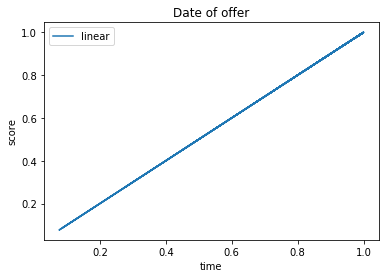

In [106]:
x = X['date_of_the_offer']

plt.plot(x, x, label='linear')

plt.xlabel('time')
plt.ylabel('score')

plt.title("Date of offer")

plt.legend()

plt.show()


In [101]:
import seaborn as sns


# sns.lmplot("equipment", "price", data=filtered_class, hue="gears", fit_reg=False, col='modelLine', col_wrap=2)


### Feature Scaling

In [20]:
# TODO IMPROVE SCALING! 
# obecnie jest blad ze nie zwraca w zakresie o-1 tylko np. -5.5-0.2

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_std=True)

X_numeric_sc = scaler.fit_transform(X_numeric)
temp = pd.DataFrame(data = X_numeric_sc, columns = X_numeric.columns)
temp.head()

,total_price,furniture,area,amount_of_rooms,parking_space
0,-0.663226,0.243733,-0.239411,-0.252044,-0.727029
1,-0.247979,-4.102845,-0.277306,-0.252044,1.375461
2,-0.187798,0.243733,-0.353096,-0.252044,1.375461
3,-0.302141,0.243733,-0.466781,-0.252044,-0.727029
4,0.052925,0.243733,-0.087831,-0.252044,-0.727029


### Encode labels for categorical data - text into numbers

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()

X[:,0] = labelencoder_X.fit_transform(X[:,0])

# enc = OneHotEncoder(categorical_features = [0])
# X = enc.fit_transform(X).toarray()

### Dispatch dependent matrix and independent vector

In [ ]:
# # https://towardsdatascience.com/the-complete-beginners-guide-to-data-cleaning-and-preprocessing-2070b7d4c6d

# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# # from sklearn.cross_validation import train_test_split

# # Matrix of dependent variables:
# X = df.drop(['price', 'parsed_fields', 'offer_from', 'offer_url', 'offer_name', 'offer_thumbnail_url', 'offer_id', 'offer_text', 'creation_time', 'modification_time', 'street'], axis=1)
# X.head()
# # X=X.values

# # #vector of independent variables:
# # y = df.loc[:, ['price']]
# # y=y.values
# # X

### Split dataset into train set and test set

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)